In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import *
import cv2
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
root_dir="/content/drive/MyDrive/smoke/data/"

In [3]:
transform = transforms.Compose(
    [
    transforms.Resize((256, 256)),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
torch.cuda.empty_cache()

In [ ]:
# for label in ['not_smoking', 'smoking']: 
#   path = os.path.join(root_dir, label)  
#   for img in os.listdir(path):
#       img = os.path.join(path, img)
#       try:
#         img_array = cv2.imread(img)
#       except:
#         print(img)
#         os.remove(img)

In [ ]:
class Smoking_Dataset(Dataset):
    def __init__(self, root_dir,data_type="train", transform=transform):
      self.root_dir = root_dir
      self.transform = transform
      self.data_type = data_type
      self.files = []
      self.img = []
      self.img_path= []
      self.img_class= []
      self.label = []
      X_train, X_val, y_train, y_val = [], [], [], []
      self.labels = [file  for file in os.listdir(self.root_dir) if os.path.isdir(os.path.join(self.root_dir, file))]
      if data_type=="train":
        self.train_data = self.train_val_split(self.data_type)
      elif data_type=="validation":
        self.validation_data = self.train_val_split(self.data_type)



    def get_files(self,root_dir):
      for label in self.labels: 
        image_class = self.labels.index(label)
        path = os.path.join(root_dir, label)  
        for img in os.listdir(path):
            img = os.path.join(path, img)
            self.img_path.append(img) 
            self.img_class.append(image_class)
      return self.img_path,self.img_class


    def train_val_split(self,data_type):
      self.img_path,self.img_class= self.get_files(self.root_dir)

      self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.img_path, self.img_class, test_size=0.30)
      if self.data_type =="train":
        return [self.X_train, self.y_train]
      elif self.data_type =="validation":
        return [self.X_val, self.y_val]


    def __len__(self):
      if self.data_type =="train":
        return len(self.y_train)
      elif self.data_type =="validation":
        return len(self.y_val)

        


    def __getitem__(self, idx):
      
      if self.data_type =="train":
        self.img,self.label = self.train_data[0][idx],self.train_data[1][idx]
      elif self.data_type =="validation":
        self.img,self.label = self.validation_data[0][idx],self.validation_data[1][idx]

      self.img = Image.open(self.img).convert('RGB')
      self.img = self.transform(self.img)
      self.label = torch.from_numpy(np.array(self.label).copy())
      return self.img,self.label
  

In [ ]:
train_data=Smoking_Dataset(root_dir,data_type="train")

In [ ]:
val_data=Smoking_Dataset(root_dir,data_type="validation")

In [ ]:
len(train_data)

2291

In [ ]:
len(val_data)

982

In [ ]:
trainloader=DataLoader(train_data, batch_size=128, shuffle=True)

In [ ]:
valloader= DataLoader(val_data, batch_size=128, shuffle=True)

In [6]:
model = models.resnet18(pretrained=False).to(device)

In [7]:
model.fc=nn.Linear(model.fc.in_features,2).to(device)

In [ ]:
model.fc=nn.Linear(model.fc.in_features,len(train_data.labels)).to(device)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)

In [ ]:
def accuracy(out, yb): 
    return (torch.argmax(out, dim=1)==yb).float().mean()

In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    tloss=[]
    vloss=[]
    
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
        tot_train=0
#         print(model.training)
        for xb,yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            loss = loss_func(model(xb), yb)
            tot_train+=loss
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        nt=len(train_dl)
        
        
        model.eval()
#         print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        
        tloss.append(tot_train/nt)
        vloss.append(tot_loss/nv)
        print(epoch,tot_train/nt, tot_loss/nv, tot_acc/nv)
    return tloss, vloss

In [ ]:
train_loss,val_loss = fit(30, model, criterion, optimizer, trainloader, valloader)

0 tensor(0.4403, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.2664, device='cuda:0') tensor(0.8902, device='cuda:0')
1 tensor(0.1385, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.1491, device='cuda:0') tensor(0.9551, device='cuda:0')
2 tensor(0.0338, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.1415, device='cuda:0') tensor(0.9605, device='cuda:0')
3 tensor(0.0097, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.1360, device='cuda:0') tensor(0.9634, device='cuda:0')
4 tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.1322, device='cuda:0') tensor(0.9639, device='cuda:0')
5 tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.1329, device='cuda:0') tensor(0.9639, device='cuda:0')
6 tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.1385, device='cuda:0') tensor(0.9625, device='cuda:0')
7 tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.1463, device='cuda:0') tensor(0.9625, device='cuda:0')
8 tensor(0.0014, device=

In [13]:
PATH = '/content/drive/MyDrive/smoke/model.pt'

In [ ]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)

<All keys matched successfully>

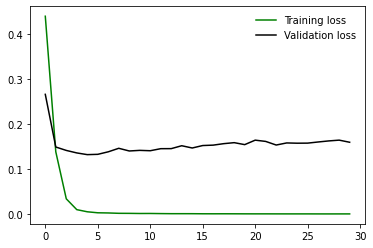

In [ ]:
plt.plot(train_loss, label='Training loss', color='green')
plt.plot(val_loss, label='Validation loss', color ='black')
plt.legend(frameon=False)
plt.show()

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [ ]:
unorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))

In [ ]:
a=unorm(data_list[1000][0])
a=a.permute(1, 2, 0)
plt.imshow(a)

In [14]:
model = models.resnet18(pretrained=False).to(device)

In [15]:
model.fc=nn.Linear(model.fc.in_features,2).to(device)

In [16]:
model.load_state_dict(torch.load(PATH)['model_state_dict'])

<All keys matched successfully>

In [19]:
torch.save(model.state_dict(), '/content/drive/MyDrive/smoke/model2.pt')

In [20]:
pwd

'/content'

In [49]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [50]:
test_image = '/content/drive/MyDrive/smoke/data/smoking/000-0.jpg'

(<matplotlib.image.AxesImage at 0x7ff06121a590>,
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

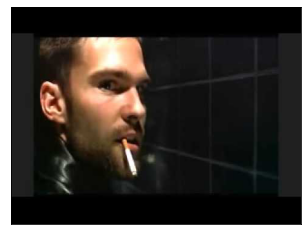

In [51]:

# First prepare the transformations: resize the image to what the model was trained on and convert it to a tensor
data_transform = transform = transforms.Compose(
    [transforms.Resize((256, 256)),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
# Load the image
image = Image.open(test_image)
plt.imshow(image), plt.xticks([]), plt.yticks([])



In [52]:
labels=['not-smoking','smoking']

In [57]:
# Now apply the transformation, expand the batch dimension, and send the image to the GPU
image = data_transform(image).unsqueeze(0).to(device)

# Get the 1000-dimensional model output
out = model(image)
# Find the predicted class
print("Predicted class is: {}".format(labels[out.argmax()]))

TypeError: ignored

In [56]:
out=out.cpu().detach().numpy()

In [59]:
out.argmax()

1